In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xverse.transformer import WOE

In [2]:
# stop warnings
import warnings 
warnings.filterwarnings('ignore')

In [3]:
sys.path.append('../scripts')

In [4]:
# Load the dataset
df = pd.read_csv('../data/data.csv')

In [5]:
df

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13T09:54:25Z,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13T09:54:35Z,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13T10:01:10Z,2,0


In [6]:
# Convert TransactionStartTime to datetime format without timezone
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], utc=True).dt.tz_localize(None)

# Verify the conversion
print("\nData type of TransactionStartTime after conversion:", df['TransactionStartTime'].dtype)

# Display the first few rows to confirm
print(df[['TransactionStartTime']].head())



Data type of TransactionStartTime after conversion: datetime64[ns]
  TransactionStartTime
0  2018-11-15 02:18:49
1  2018-11-15 02:19:08
2  2018-11-15 02:44:21
3  2018-11-15 03:32:55
4  2018-11-15 03:34:21


In [7]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21,2,0


### Aggregate Features

In [8]:
def create_aggregate_features(df):

    # Ensure datetime format
    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], format='%Y-%m-%d %H:%M:%S%z')

    # Extract temporal features
    df['TransactionHour'] = df['TransactionStartTime'].dt.hour
    df['TransactionDay'] = df['TransactionStartTime'].dt.day
    df['TransactionMonth'] = df['TransactionStartTime'].dt.month
    df['TransactionYear'] = df['TransactionStartTime'].dt.year

    # Aggregate transaction data by CustomerId
    df_agg = df.groupby('CustomerId').agg({
        'TransactionStartTime': lambda x: (x.max() - x.min()).days,
        'TransactionId': 'count',
        'Amount': ['sum', 'mean', 'std'],
        'TransactionHour': 'mean',
        'TransactionDay': 'mean',
        'TransactionMonth': 'mean',
        'TransactionYear': 'mean'
    }).reset_index()

    # Rename the columns
    df_agg.columns = ['CustomerId', 'Recency', 'Frequency', 'Monetary', 'MeanAmount',
                      'StdAmount', 'AvgTransactionHour', 'AvgTransactionDay', 'AvgTransactionMonth',
                      'AvgTransactionYear']

    # Calculate additional features
    total_debits = df[df['Amount'] > 0].groupby('CustomerId')['Amount'].sum()
    total_credits = df[df['Amount'] < 0].groupby('CustomerId')['Amount'].sum()
    debit_count = df[df['Amount'] > 0].groupby('CustomerId')['TransactionId'].count()
    credit_count = df[df['Amount'] < 0].groupby('CustomerId')['TransactionId'].count()
    transaction_volatility = df.groupby('CustomerId')['Amount'].std()

    # Merge additional features
    df_agg = df_agg.merge(total_debits.rename('TotalDebits'), on='CustomerId', how='left')
    df_agg = df_agg.merge(total_credits.rename('TotalCredits'), on='CustomerId', how='left')
    df_agg = df_agg.merge(debit_count.rename('DebitCount'), on='CustomerId', how='left')
    df_agg = df_agg.merge(credit_count.rename('CreditCount'), on='CustomerId', how='left')
    df_agg = df_agg.merge(transaction_volatility.rename('TransactionVolatility'), on='CustomerId', how='left')

    # Calculate derived features
    df_agg['MonetaryAmount'] = df_agg['TotalDebits'] + abs(df_agg['TotalCredits'])
    df_agg['NetCashFlow'] = df_agg['TotalDebits'] - abs(df_agg['TotalCredits'])
    df_agg['DebitCreditRatio'] = df_agg['TotalDebits'] / abs(df_agg['TotalCredits'])

    return df_agg.dropna()

In [9]:
df_aggregated= create_aggregate_features(df)
df_aggregated

,CustomerId,Recency,Frequency,Monetary,MeanAmount,StdAmount,AvgTransactionHour,AvgTransactionDay,AvgTransactionMonth,AvgTransactionYear,TotalDebits,TotalCredits,DebitCount,CreditCount,TransactionVolatility,MonetaryAmount,NetCashFlow,DebitCreditRatio
2,CustomerId_1001,0,5,20000.0,4000.000000,6558.963333,7.800000,16.000000,11.000000,2018.000000,25200.0,-5200.0,3.0,2.0,6558.963333,30400.0,20000.0,4.846154
3,CustomerId_1002,63,11,4225.0,384.090909,560.498966,13.454545,14.727273,8.636364,2018.272727,4500.0,-275.0,5.0,6.0,560.498966,4775.0,4225.0,16.363636
4,CustomerId_1003,0,6,20000.0,3333.333333,6030.478146,14.333333,1.000000,2.000000,2019.000000,26000.0,-6000.0,4.0,2.0,6030.478146,32000.0,20000.0,4.333333
6,CustomerId_1005,0,9,48800.0,5422.222222,5983.681513,10.111111,28.000000,12.000000,2018.000000,55000.0,-6200.0,6.0,3.0,5983.681513,61200.0,48800.0,8.870968
11,CustomerId_1010,12,7,26335.0,3762.142857,4971.798817,11.428571,15.571429,8.857143,2018.285714,28000.0,-1665.0,4.0,3.0,4971.798817,29665.0,26335.0,16.816817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,CustomerId_992,0,6,20000.0,3333.333333,6088.240030,10.000000,8.000000,2.000000,2019.000000,26000.0,-6000.0,4.0,2.0,6088.240030,32000.0,20000.0,4.333333
3738,CustomerId_993,0,5,20000.0,4000.000000,6745.368782,15.000000,18.000000,1.000000,2019.000000,26000.0,-6000.0,3.0,2.0,6745.368782,32000.0,20000.0,4.333333
3739,CustomerId_994,88,101,543873.0,5384.881188,14800.656784,13.900990,18.475248,5.207921,2018.623762,578000.0,-34127.0,61.0,40.0,14800.656784,612127.0,543873.0,16.936736
3740,CustomerId_996,0,17,139000.0,8176.470588,4433.329648,14.470588,7.000000,12.000000,2018.000000,145000.0,-6000.0,15.0,2.0,4433.329648,151000.0,139000.0,24.166667


In [10]:
df_aggregated.isna().sum()

CustomerId               0
Recency                  0
Frequency                0
Monetary                 0
MeanAmount               0
StdAmount                0
AvgTransactionHour       0
AvgTransactionDay        0
AvgTransactionMonth      0
AvgTransactionYear       0
TotalDebits              0
TotalCredits             0
DebitCount               0
CreditCount              0
TransactionVolatility    0
MonetaryAmount           0
NetCashFlow              0
DebitCreditRatio         0
dtype: int64

### Encode Categorical Variables

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def encode_categorical_variables(df):

    try:
        # Copy the DataFrame to avoid modifying the original
        df = df.copy()

        # Initialize a LabelEncoder instance
        label_encoders = {}
        
        # Label Encoding for each categorical column
        for col in df.select_dtypes(include=['object']).columns:
            label_encoders[col] = LabelEncoder()
            df[col] = label_encoders[col].fit_transform(df[col])

        return df
    except Exception as e:
        print(f"Error occurred during encoding categorical variables: {e}")
        return None


In [12]:
df_encoded = encode_categorical_variables(df_aggregated)
df_encoded.head()

,CustomerId,Recency,Frequency,Monetary,MeanAmount,StdAmount,AvgTransactionHour,AvgTransactionDay,AvgTransactionMonth,AvgTransactionYear,TotalDebits,TotalCredits,DebitCount,CreditCount,TransactionVolatility,MonetaryAmount,NetCashFlow,DebitCreditRatio
2,0,0,5,20000.0,4000.000000,6558.963333,7.800000,16.000000,11.000000,2018.000000,25200.0,-5200.0,3.0,2.0,6558.963333,30400.0,20000.0,4.846154
3,1,63,11,4225.0,384.090909,560.498966,13.454545,14.727273,8.636364,2018.272727,4500.0,-275.0,5.0,6.0,560.498966,4775.0,4225.0,16.363636
4,2,0,6,20000.0,3333.333333,6030.478146,14.333333,1.000000,2.000000,2019.000000,26000.0,-6000.0,4.0,2.0,6030.478146,32000.0,20000.0,4.333333
6,3,0,9,48800.0,5422.222222,5983.681513,10.111111,28.000000,12.000000,2018.000000,55000.0,-6200.0,6.0,3.0,5983.681513,61200.0,48800.0,8.870968
11,4,12,7,26335.0,3762.142857,4971.798817,11.428571,15.571429,8.857143,2018.285714,28000.0,-1665.0,4.0,3.0,4971.798817,29665.0,26335.0,16.816817


### Visualization of the Transactions in RFMS space

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt


# import matplotlib
# matplotlib.use('inline')

def visualize_rfms_space(df):
    # Extract the RFMS scores
    r_score = df['Recency']
    f_score = df['Frequency']
    m_score = df['Monetary']
    debit_credit_ratio = df['DebitCreditRatio']
    transaction_volatility = df['TransactionVolatility']

    # Visualize the RFMS space
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(r_score, f_score, c=debit_credit_ratio, cmap='viridis')
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    plt.title('RFMS Space')

    # Defining the boundary between high and low RFMS scores
    r_threshold = np.percentile(r_score, 60)
    f_threshold = np.percentile(f_score, 50)
    m_threshold = np.percentile(m_score, 50)
    dc_threshold = np.percentile(debit_credit_ratio, 60)
    tv_threshold = np.percentile(transaction_volatility, 50)

    # Plot the thresholds
    ax.axvline(x=r_threshold, color='r', linestyle='--', label='Recency Threshold')
    ax.axhline(y=f_threshold, color='g', linestyle='--', label='Frequency Threshold')
    ax.plot(r_threshold, f_threshold, 'bo', label='Monetary Threshold')

    ax.legend()
    plt.colorbar(scatter, label='Debit Credit Ratio')

    plt.show()

    return r_threshold, f_threshold, m_threshold, dc_threshold, tv_threshold


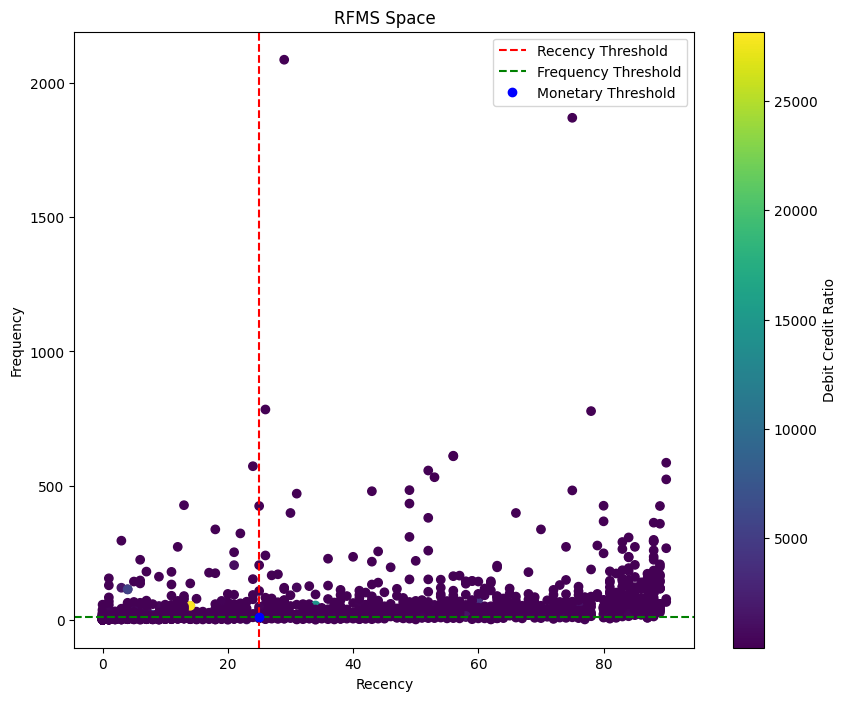

In [14]:
r_threshold, f_threshold, m_threshold, dc_threshold, tv_threshold = visualize_rfms_space(df_encoded)

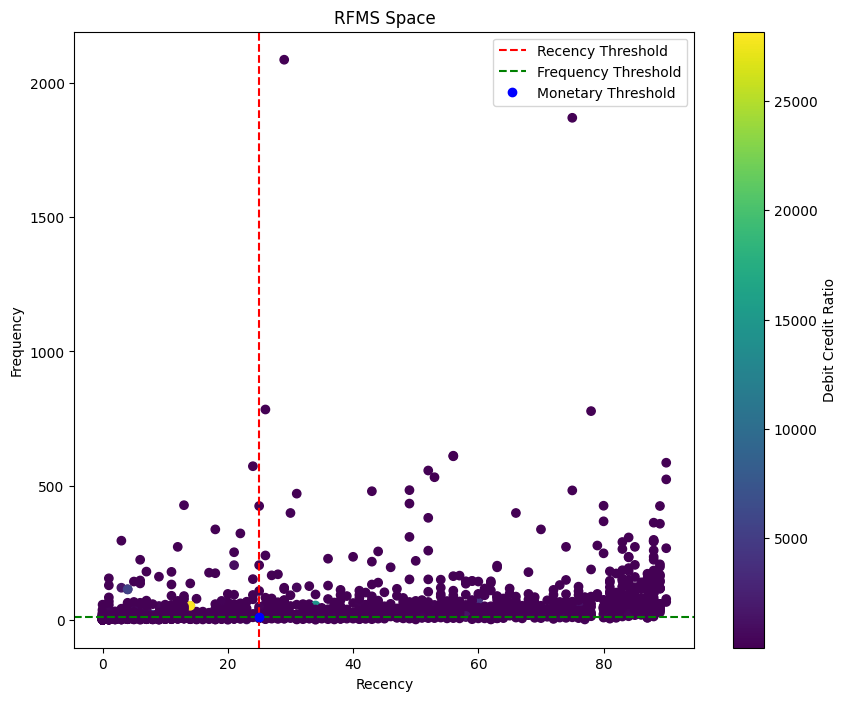

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_rfms_space(df):
    # Check if the DataFrame has the necessary columns
    required_columns = ['Recency', 'Frequency', 'Monetary', 'DebitCreditRatio', 'TransactionVolatility']
    if not all(col in df.columns for col in required_columns):
        print(f"Missing columns in DataFrame: {set(required_columns) - set(df.columns)}")
        return None

    # Extract the RFMS scores
    r_score = df['Recency']
    f_score = df['Frequency']
    m_score = df['Monetary']
    debit_credit_ratio = df['DebitCreditRatio']
    transaction_volatility = df['TransactionVolatility']

    # Visualize the RFMS space
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(r_score, f_score, c=debit_credit_ratio, cmap='viridis')
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    plt.title('RFMS Space')

    # Defining the boundary between high and low RFMS scores
    r_threshold = np.percentile(r_score, 60)
    f_threshold = np.percentile(f_score, 50)
    m_threshold = np.percentile(m_score, 50)
    dc_threshold = np.percentile(debit_credit_ratio, 60)
    tv_threshold = np.percentile(transaction_volatility, 50)

    # Plot the thresholds
    ax.axvline(x=r_threshold, color='r', linestyle='--', label='Recency Threshold')
    ax.axhline(y=f_threshold, color='g', linestyle='--', label='Frequency Threshold')
    ax.plot(r_threshold, f_threshold, 'bo', label='Monetary Threshold')

    ax.legend()
    plt.colorbar(scatter, label='Debit Credit Ratio')

    plt.show()

    return r_threshold, f_threshold, m_threshold, dc_threshold, tv_threshold

# Example usage
r_threshold, f_threshold, m_threshold, dc_threshold, tv_threshold = visualize_rfms_space(df_encoded)


### Classify Users Based on RFMS

In [36]:
def classify_users_by_rfms(df, r_threshold, f_threshold, m_threshold, dc_threshold, tv_threshold):
    df['Classification'] = 'High-risk'

    # Identify Low-risk users based on RFMS thresholds
    df.loc[(df['Recency'] <= r_threshold) & (df['Frequency'] >= f_threshold) & (
        df['Monetary'] >= m_threshold), 'Classification'] = 'Low-risk'

    # Reclassify users with low debit-credit ratio and low transaction volatility as Low-risk
    df.loc[(df['Classification'] == 'High-risk') & (
        df['DebitCreditRatio'] <= dc_threshold) & (
        df['TransactionVolatility'] <= tv_threshold), 'Classification'] = 'Low-risk'

    df['Risk'] = (df['Classification'] == 'High-risk').astype(int)

    return df

In [37]:
df_classified = classify_users_by_rfms(df_encoded, r_threshold, f_threshold, m_threshold,dc_threshold, tv_threshold)
df_classified.head()

,CustomerId,Recency,Frequency,Monetary,MeanAmount,StdAmount,AvgTransactionHour,AvgTransactionDay,AvgTransactionMonth,AvgTransactionYear,...,TotalCredits,DebitCount,CreditCount,TransactionVolatility,MonetaryAmount,NetCashFlow,DebitCreditRatio,Classification,Label,Risk
2,0,0,5,20000.0,4000.000000,6558.963333,7.800000,16.000000,11.000000,2018.000000,...,-5200.0,3.0,2.0,6558.963333,30400.0,20000.0,4.846154,High-risk,bad,1
3,1,63,11,4225.0,384.090909,560.498966,13.454545,14.727273,8.636364,2018.272727,...,-275.0,5.0,6.0,560.498966,4775.0,4225.0,16.363636,High-risk,bad,1
4,2,0,6,20000.0,3333.333333,6030.478146,14.333333,1.000000,2.000000,2019.000000,...,-6000.0,4.0,2.0,6030.478146,32000.0,20000.0,4.333333,High-risk,bad,1
6,3,0,9,48800.0,5422.222222,5983.681513,10.111111,28.000000,12.000000,2018.000000,...,-6200.0,6.0,3.0,5983.681513,61200.0,48800.0,8.870968,High-risk,bad,1
11,4,12,7,26335.0,3762.142857,4971.798817,11.428571,15.571429,8.857143,2018.285714,...,-1665.0,4.0,3.0,4971.798817,29665.0,26335.0,16.816817,High-risk,bad,1


In [38]:
print(df_classified[['Classification', 'Label']].head(10))
print("\nLabel distribution:")
print(df_classified['Label'].value_counts(normalize=True))

   Classification Label
2       High-risk   bad
3       High-risk   bad
4       High-risk   bad
6       High-risk   bad
11      High-risk   bad
12      High-risk   bad
14      High-risk   bad
15      High-risk   bad
18      High-risk   bad
19      High-risk   bad

Label distribution:
Label
bad     0.644074
good    0.355926
Name: proportion, dtype: float64


### Weight of Evidence (WoE) Binning

In [39]:
def calculate_woe_and_bin_features(data, features_to_bin, target, num_bins=5):

    def woe_binning(df, feature, target):
    
        woe_dict = {}
        total_good = df[target].sum()
        total_bad = df[target].count() - total_good

        for bin_id in df[feature].unique():
            bin_data = df[df[feature] == bin_id]
            good = bin_data[target].sum()
            bad = bin_data[target].count() - good

            if good == 0 or bad == 0:
                woe = 0 
            else:
                woe = np.log((good / total_good) / (bad / total_bad))

            woe_dict[bin_id] = woe

        return woe_dict

    def create_binned_features(df, features, num_bins):
    
        for feature in features:
            df[f"{feature}_binned"] = pd.qcut(df[feature], q=num_bins, labels=False, duplicates='drop')
        return df

    # Ensure the target feature is included in the returned DataFrame
    data[target] = data[target]

    # Create binned features
    data = create_binned_features(data, features_to_bin, num_bins)

    # Calculate WoE for binned features
    for feature in features_to_bin:
        binned_feature = f"{feature}_binned"
        woe_dict = woe_binning(data, binned_feature, target)
        data[f'{binned_feature}_WoE'] = data[binned_feature].map(woe_dict)

    # Drop binned features
    binned_columns = [f"{feature}_binned" for feature in features_to_bin]
    data.drop(columns=binned_columns, inplace=True)

    return data

In [33]:
def calculate_woe_and_bin_features(data, features_to_bin, target, num_bins=5):
    
    def woe_binning(df, feature, target):
    
        woe_dict = {}
        total_good = df[target].sum()
        total_bad = df[target].count() - total_good

        for bin_id in df[feature].unique():
            bin_data = df[df[feature] == bin_id]
            good = bin_data[target].sum()
            bad = bin_data[target].count() - good

            if good == 0 or bad == 0:
                woe = 0 
            else:
                woe = np.log((good / total_good) / (bad / total_bad))

            woe_dict[bin_id] = woe

        return woe_dict

    def create_binned_features(df, features, num_bins):
    
        for feature in features:
            df[f"{feature}_binned"] = pd.qcut(df[feature], q=num_bins, labels=False, duplicates='drop')
        return df

    # Ensure the target feature is included in the returned DataFrame
    data[target] = data[target]

    # Create binned features
    data = create_binned_features(data, features_to_bin, num_bins)

    # Calculate WoE for binned features
    for feature in features_to_bin:
        binned_feature = f"{feature}_binned"
        woe_dict = woe_binning(data, binned_feature, target)
        data[f'{binned_feature}_WoE'] = data[binned_feature].map(woe_dict)

    # Drop binned features
    binned_columns = [f"{feature}_binned" for feature in features_to_bin]
    data.drop(columns=binned_columns, inplace=True)

    return data

In [40]:
df_filtered=df_classified.drop(['Classification'], axis=1)
features_to_bin = ['Recency', 'Frequency', 'Monetary', 'MeanAmount',
       'StdAmount', 'AvgTransactionHour', 'AvgTransactionDay',
       'AvgTransactionMonth', 'AvgTransactionYear', 'TotalDebits',
       'TotalCredits', 'DebitCount', 'CreditCount', 'TransactionVolatility',
       'MonetaryAmount', 'NetCashFlow', 'DebitCreditRatio']
target = 'Risk'


In [41]:
df_woe = calculate_woe_and_bin_features(df_filtered, features_to_bin, target)
df_woe

,CustomerId,Recency,Frequency,Monetary,MeanAmount,StdAmount,AvgTransactionHour,AvgTransactionDay,AvgTransactionMonth,AvgTransactionYear,...,AvgTransactionMonth_binned_WoE,AvgTransactionYear_binned_WoE,TotalDebits_binned_WoE,TotalCredits_binned_WoE,DebitCount_binned_WoE,CreditCount_binned_WoE,TransactionVolatility_binned_WoE,MonetaryAmount_binned_WoE,NetCashFlow_binned_WoE,DebitCreditRatio_binned_WoE
2,0,0,5,20000.0,4000.000000,6558.963333,7.800000,16.000000,11.000000,2018.000000,...,0.485419,0.153039,0.885726,0.788475,0.097926,0.077498,1.411927,1.043871,0.848572,0.331167
3,1,63,11,4225.0,384.090909,560.498966,13.454545,14.727273,8.636364,2018.272727,...,0.485419,0.153039,-1.314731,-0.245335,0.278747,-0.331822,-0.756022,-1.314731,-1.230044,1.370248
4,2,0,6,20000.0,3333.333333,6030.478146,14.333333,1.000000,2.000000,2019.000000,...,-0.295459,-0.463634,0.885726,0.788475,0.278747,0.077498,-0.265469,1.043871,0.848572,0.331167
6,3,0,9,48800.0,5422.222222,5983.681513,10.111111,28.000000,12.000000,2018.000000,...,-0.138449,0.153039,0.765032,0.264165,0.278747,0.362420,-0.265469,0.609240,0.495445,-0.952987
11,4,12,7,26335.0,3762.142857,4971.798817,11.428571,15.571429,8.857143,2018.285714,...,0.485419,0.153039,0.885726,-0.507697,0.278747,0.362420,-0.265469,1.043871,0.495445,1.370248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,2636,0,6,20000.0,3333.333333,6088.240030,10.000000,8.000000,2.000000,2019.000000,...,-0.295459,-0.463634,0.885726,0.788475,0.278747,0.077498,-0.265469,1.043871,0.848572,0.331167
3738,2637,0,5,20000.0,4000.000000,6745.368782,15.000000,18.000000,1.000000,2019.000000,...,-0.627121,-0.463634,0.885726,0.788475,0.097926,0.077498,1.411927,1.043871,0.848572,0.331167
3739,2638,88,101,543873.0,5384.881188,14800.656784,13.900990,18.475248,5.207921,2018.623762,...,0.776712,0.774511,0.336622,-0.132277,0.102909,0.217838,0.685424,0.309954,0.321874,1.370248
3740,2639,0,17,139000.0,8176.470588,4433.329648,14.470588,7.000000,12.000000,2018.000000,...,-0.138449,0.153039,-0.317438,0.788475,-0.116858,0.077498,-0.265469,-0.284426,0.321874,1.370248


In [42]:
df_woe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2641 entries, 2 to 3741
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CustomerId                        2641 non-null   int64  
 1   Recency                           2641 non-null   int64  
 2   Frequency                         2641 non-null   int64  
 3   Monetary                          2641 non-null   float64
 4   MeanAmount                        2641 non-null   float64
 5   StdAmount                         2641 non-null   float64
 6   AvgTransactionHour                2641 non-null   float64
 7   AvgTransactionDay                 2641 non-null   float64
 8   AvgTransactionMonth               2641 non-null   float64
 9   AvgTransactionYear                2641 non-null   float64
 10  TotalDebits                       2641 non-null   float64
 11  TotalCredits                      2641 non-null   float64
 12  DebitCount 

In [43]:
df_corr = df_woe.drop(['CustomerId', 'Recency', 'Frequency', 'Monetary', 'MeanAmount',
       'StdAmount', 'AvgTransactionHour', 'AvgTransactionDay',
       'AvgTransactionMonth', 'AvgTransactionYear', 'TotalDebits',
       'TotalCredits', 'DebitCount', 'CreditCount', 'TransactionVolatility',
       'MonetaryAmount', 'NetCashFlow', 'DebitCreditRatio'], axis=1)

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
df_woe['Label'] = df_woe['Label'].map({'bad': 0, 'good': 1})
corr_matrix = df_woe.corr()
X = df_woe.drop('Risk', axis=1)
y = df_woe['Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Random Forest model
rf = RandomForestRegressor()
rfe = RFE(rf, n_features_to_select=12)
rfe.fit(X_train, y_train)

features_selected = X_train.columns[rfe.support_]

In [45]:
features_selected

Index(['Label', 'AvgTransactionDay_binned_WoE',
       'AvgTransactionMonth_binned_WoE', 'AvgTransactionYear_binned_WoE',
       'TotalDebits_binned_WoE', 'TotalCredits_binned_WoE',
       'DebitCount_binned_WoE', 'CreditCount_binned_WoE',
       'TransactionVolatility_binned_WoE', 'MonetaryAmount_binned_WoE',
       'NetCashFlow_binned_WoE', 'DebitCreditRatio_binned_WoE'],
      dtype='object')

In [46]:
keep_features = ['Recency_binned_WoE',
                 'Frequency_binned_WoE',
                 'MeanAmount_binned_WoE',
                 'StdAmount_binned_WoE',
                 'AvgTransactionHour_binned_WoE',
                 'TotalDebits_binned_WoE',
                 'DebitCount_binned_WoE',
                 'CreditCount_binned_WoE',
                 'TransactionVolatility_binned_WoE',
                 'MonetaryAmount_binned_WoE',
                 'NetCashFlow_binned_WoE',
                 'DebitCreditRatio_binned_WoE',
                 'Risk']

In [47]:
df_selected = df_woe[keep_features]

In [48]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2641 entries, 2 to 3741
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Recency_binned_WoE                2641 non-null   float64
 1   Frequency_binned_WoE              2641 non-null   float64
 2   MeanAmount_binned_WoE             2641 non-null   float64
 3   StdAmount_binned_WoE              2641 non-null   float64
 4   AvgTransactionHour_binned_WoE     2641 non-null   float64
 5   TotalDebits_binned_WoE            2641 non-null   float64
 6   DebitCount_binned_WoE             2641 non-null   float64
 7   CreditCount_binned_WoE            2641 non-null   float64
 8   TransactionVolatility_binned_WoE  2641 non-null   float64
 9   MonetaryAmount_binned_WoE         2641 non-null   float64
 10  NetCashFlow_binned_WoE            2641 non-null   float64
 11  DebitCreditRatio_binned_WoE       2641 non-null   float64
 12  Risk       

In [49]:
df_shuffled = df_selected.sample(frac=1.0)
df_shuffled

,Recency_binned_WoE,Frequency_binned_WoE,MeanAmount_binned_WoE,StdAmount_binned_WoE,AvgTransactionHour_binned_WoE,TotalDebits_binned_WoE,DebitCount_binned_WoE,CreditCount_binned_WoE,TransactionVolatility_binned_WoE,MonetaryAmount_binned_WoE,NetCashFlow_binned_WoE,DebitCreditRatio_binned_WoE,Risk
1824,-1.272253,-0.432276,-1.147513,-0.494527,-0.106436,-1.314731,-0.416865,0.362420,-0.494527,1.043871,-1.230044,-0.855456,0
2547,-1.272253,-0.075730,0.576980,-0.265469,0.007682,-0.317438,-0.116858,-0.262379,-0.265469,-0.284426,-0.170235,0.685424,0
2755,0.941720,-0.075730,0.195366,-0.265469,0.007682,0.765032,-0.116858,-0.262379,-0.265469,-0.284426,0.495445,-0.855456,0
2809,0.941720,-0.432276,0.195366,1.411927,0.007682,-0.317438,-0.416865,-0.262379,1.411927,-0.284426,-0.170235,-0.855456,1
2419,-1.272253,-0.432276,0.195366,-0.494527,-0.057949,0.765032,-0.416865,-0.331822,-0.494527,0.609240,0.495445,1.370248,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,-0.066885,-0.075730,0.195366,0.685424,0.124153,-0.317438,-0.116858,-0.262379,0.685424,-0.284426,-0.170235,0.685424,0
3072,-1.272253,-0.432276,-0.241014,-0.494527,0.007682,0.885726,-0.416865,-0.262379,-0.494527,1.043871,0.495445,1.370248,1
174,-0.066885,0.405803,0.914488,1.411927,-0.106436,0.765032,0.278747,0.077498,1.411927,0.609240,0.495445,-0.952987,1
1243,0.908668,-0.075730,0.195366,-0.494527,0.124153,-0.317438,-0.116858,-0.262379,-0.494527,0.609240,-0.170235,0.685424,1


In [66]:
# Save the feature engineered dataset
df_woe.to_csv('../data/feature_data.csv', index=False)